In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

('2017-08-23',)


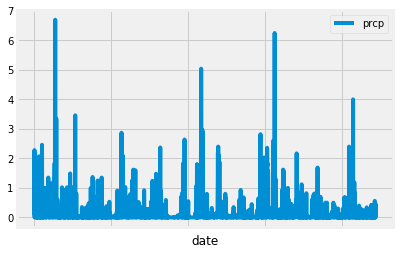

In [11]:
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)
# Calculate the date 1 year ago from the last data point in the database
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
             filter(Measurement.date>'2016-08-23').\
             order_by(Measurement.date).all()
# create dataframe
# replace NAN with 0
df = pd.DataFrame(precipitation_data)
df.fillna(0, inplace = True)
# plot line graph 
df.plot(kind="line", x="date", y="prcp")

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data


![precipitation](Images/precipitation.png)

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_data = df.describe()
precipitation_data

,prcp
count,2223.000000
mean,0.159951
std,0.441220
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(func.count(Station.station)).all()
stations

[(9)]

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_stations= session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# create dataframe and find the most active station
most_active_stations_df = pd.DataFrame(data=most_active_stations, columns=['Station', 'Count'])
most_active_station = most_active_stations_df["Station"][0]
most_active_station

'USC00519281'

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_station_temp = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
              group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
most_active_station_temp

(54.0, 85.0, 71.66378066378067)

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_observations = session.query(Measurement.station, func.count(Measurement.station)).\
              filter(Measurement.date > '2016-08-23').\
              group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
temperature_observations

('USC00519397', 360)

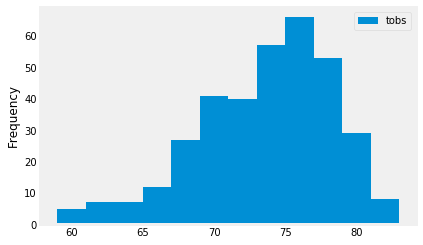

In [19]:
temperature_observations_total = session.query(Measurement.tobs).\
    filter(Measurement.date >= '2016-08-23').\
    filter(Measurement.station == most_active_station).\
    order_by(Measurement.tobs).all()
# create dataframe
temperature_observations_total_df = pd.DataFrame(temperature_observations_total, columns=['Tobs'])
# Plot the results as a histogram 
plt.hist(temperature_observations_total_df.Tobs,bins=12)
plt.legend(["tobs"])
plt.ylabel('Frequency')
plt.grid()

plt.show()

![precipitation](Images/station-histogram.png)

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
vacation = (calc_temps('2017-04-15', '2017-04-22'))
vacation

[(67.0, 72.68, 83.0)]

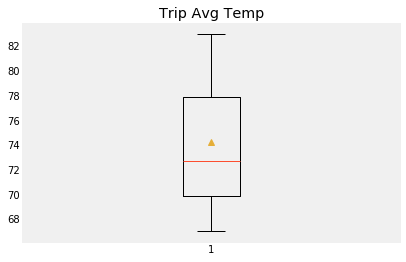

In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.title('Trip Avg Temp')
plt.boxplot(vacation, showmeans=True)
plt.grid()
plt.show()

In [24]:
# Calculate the total amount of rainfall per weather station for your trip dates using 'the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rainfalljoin = session.query(Station.name, Measurement.station, func.sum(Measurement.prcp), Station.latitude, Station.longitude).group_by(Measurement.station).filter(Station.station == Measurement.station).filter(Measurement.date.between('2016-08-23', '2017-08-23')).all()
#rainfalljoin 


railfalljoin_df = pd.DataFrame(rainfalljoin, columns=['Name', 'Station', 'Rainfall', 'Lat.', 'Long.'])
railfalljoin_df

,Name,Station,Rainfall,Lat.,Long.
0,"KANEOHE 838.1, HI US",USC00513117,48.51,21.42340,-157.80150
1,"KUALOA RANCH HEADQUARTERS 886.9, HI US",USC00514830,33.24,21.52130,-157.83740
2,"MANOA LYON ARBO 785.2, HI US",USC00516128,147.81,21.33310,-157.80250
3,"PEARL CITY, HI US",USC00517948,4.59,21.39340,-157.97510
4,"WAIHEE 837.5, HI US",USC00519281,70.03,21.45167,-157.84889
5,"WAIKIKI 717.2, HI US",USC00519397,16.09,21.27160,-157.81680
6,"WAIMANALO EXPERIMENTAL FARM, HI US",USC00519523,38.01,21.33556,-157.71139


## Optional Challenge Assignment

In [27]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("04-13")

[(64.0, 71.52542372881356, 79.0)]

In [33]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [34]:

# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
mytrip = daily_normals("04-13")
mintemptrip = mytrip[0][0]
avgtemptrip = mytrip[0][1]
maxtemptrip = mytrip[0][2]
mytripDailylist = [mintemptrip, avgtemptrip, maxtemptrip]

In [35]:
# Set the start and end date of the trip
startdate = '2016-04-13'
enddate = '2016-04-21'
# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings

tripdates = session.query(func.strftime("%m-%d", Measurement.date)).filter(Measurement.date >= startdate).filter(Measurement.date <= enddate).group_by(Measurement.date).all()
#tripdates

# Loop through the list of %m-%d strings and calculate the normals for each date
# tripdates_tobs = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date >= startdate).filter(Measurement.date <= enddate).group_by(Measurement.date).all()
# tripdates_tobs

sel = [func.strftime("%m-%d", Measurement.date), func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
tripdailys = session.query(*sel).filter(Measurement.date >= startdate, Measurement.date <= enddate).group_by(Measurement.date).all()
tripdailys

[('04-13', 71.0, 75.16666666666667, 77.0),
 ('04-14', 71.0, 74.83333333333333, 77.0),
 ('04-15', 70.0, 75.66666666666667, 79.0),
 ('04-16', 72.0, 75.4, 80.0),
 ('04-17', 66.0, 70.33333333333333, 74.0),
 ('04-18', 68.0, 71.85714285714286, 76.0),
 ('04-19', 67.0, 71.33333333333333, 74.0),
 ('04-20', 69.0, 73.14285714285714, 75.0),
 ('04-21', 68.0, 73.57142857142857, 76.0)]

In [36]:

tripdates_list = [i[0] for i in tripdates]
tripdates_list

['04-13',
 '04-14',
 '04-15',
 '04-16',
 '04-17',
 '04-18',
 '04-19',
 '04-20',
 '04-21']

In [37]:

# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
tripdailys_df = pd.DataFrame(tripdailys, columns=['date', 'min. Temp', 'avg. Temp', 'max. Temp'])
tripdailys_df = tripdailys_df.set_index('date')
tripdailys_df

,min. Temp,avg. Temp,max. Temp
date,,,
04-13,71.0,75.166667,77.0
04-14,71.0,74.833333,77.0
04-15,70.0,75.666667,79.0
04-16,72.0,75.400000,80.0
04-17,66.0,70.333333,74.0
04-18,68.0,71.857143,76.0
04-19,67.0,71.333333,74.0
04-20,69.0,73.142857,75.0
04-21,68.0,73.571429,76.0


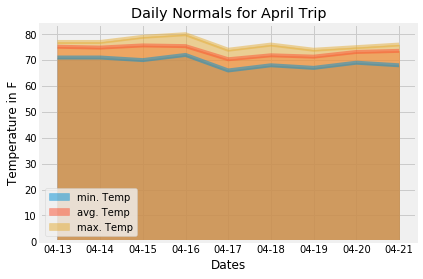

In [39]:
# Plot the daily normals as an area plot with `stacked=False`

# Plot the daily normals as an area plot with `stacked=False`
ax = tripdailys_df.plot.area(stacked=False, title="Daily Normals for April Trip")

plt.xlabel("Dates")
plt.ylabel("Temperature in F")
ax.set_xticks(range(len(tripdates_list)))
ax.set_xticklabels(tripdates_list)
plt.savefig("Images/DailyNormals.jpg")